# <span style="color:#3498db">**A mini-tutorial**</span>

This codebook is an simple example to illustrate a basic question on time frequency analysis: assessing the significance of increases in spectral power using permutation statistics. As the reader may know, there is a number of approaches to correct for multiple comparisons and reduce false positives, etc, depending on the dimensions of the data at hand. Be these spatial locations, time and frequency windows or trials of different conditions.  

Here I focus on increases relative to baseline using two variants of the same method: nul distribution testing using the traditional min-max approach, which captures the variations at the extreme of the null ditribution, and null distribution testing using the whole nul distribution. I invite the reader to audit the code and propvide feedback and comments. 

Depending on the approach, the computation of the p-values will change slightly. In the min-max approach the minimum and maximum values at each permutations are used. When testing using the whole null distribution, the permutations are averaged and the dimensions of the empirical distributions are preserved. In both cases the empirical cumulative distribution is obtained and used to obtain p-values.

An optional step is illustrated in which cluster correction of the p-values is implemented. Since there are several ways to achieve these goals and many differences exist among the different realizations of these and other related methods (i.e. thresholds may be obtaind from the percentiles of the null distribution directly and further corrected in equivalent ways, or the pooling of data for multiple comparison correction accomplished among different dimensions), here I focus on two common methods using very simple examples in the hope to help the researchers in need of clarity on these matters. 

Provided the right Python environment and data, this Jupyter notebook should work as a simple mini-tutorial to help discuss basic approaches for computing TFRs and assess their statistical significance in a *toolbox free*, transparent, barebones DIY way. The functions within this notebook are provided in an exploratory state and are subject to change. As such, the docstrings, comments and input dictionaries haven to yet been thoroughly implemented/optimized. An **Python package** is provided in any case ;) 

## Import libraries and define functions

In [3]:
import numpy as np
from tqdm.auto import tqdm
import scipy.io as sio
from numpy import inf
from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import matplotlib.colors as colors
import warnings
warnings.filterwarnings('ignore')

def tfr_spw_stats_minmax(paths, cond, svar, fband, n_perm):
    

    """
    Permutation based TFR statistical asessement based on min-max

    Function to compute the truncated min-max distribution keeping the permutations 
    for each condition and recording site. It captures the variations at the extreme 
    of the null ditribution. In the min-max approach the minimum and maximum values 
    at each permutations are used. 
    
    In the current example we use the min/max of frequencies pooled in the  400-1000 ms time window.

    It relies on ftPool_... .mat containing the TFRs computed in Fieldtrip.

    Args:
        paths: two strings (input and output paths)
        condition: an integer
        svar: spectral power or GPR (not implemented here), integer
        fband: frequency band index (i.e. low, high, higher), integer
        n_perm: number of permutations, integer

    Returns and saves:
        empirical tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )
        null tfr: n_perm x n_conds x n_sites x frequencies x min/max (i.e. 1000, 30, 12, 16, 2 )

    @author: Nicolás Gravel, 19.09.2023  
    
    https://nicogravel.github.io/
    
    """

    tps = [57,113,141,140]
    fps = [19,16,11,1]
    fbands  = ['low','high','higher']
    blocks  = ['grat', 'nat']
    svars   = ['spw', 'gpr']
    methods = ['hanning', 'wavelet','wavelet']
    svar = 0
    # Conditions
    if cond == 0:
        block = 0
        n_sess = 10
    # =============================================================================
    else:
        block = 1
        n_sess = 11


    # =============================================================================
    # How the indices are organized within the dataset
    # =============================================================================
    channels = [i for i in range(12*n_sess)] # Total channels
    site_idx = np.zeros((12,n_sess)).astype(np.uint) # Index to sites
    for n in range(12): # for time
            site = [x for x in channels if x%12 == n]
            site_idx[n,:] = site
    print('site indices :')
    print(site_idx)

    if fband == 0:
         bs_t0 = -700
         bs_t1 = -100
    elif fband == 1:
         bs_t0 = -700
         bs_t1 = -100
    elif fband == 2:
         bs_t0 = -700
         bs_t1 = -100

    # =============================================================================
    # Empirical TFR
    # =============================================================================
    fname = str(paths[0]
                + 'ftPool_'
                + blocks[block] + '_'
                + fbands[fband] + '_'
                + methods[fband] + '.mat')
    print(fname)
    mat = sio.loadmat(fname)
    dataPool = mat.get(str('dataLump_' + svars[svar]))



    print(dataPool.shape)
    time =  np.linspace(start = -800, stop = 2000, num = tps[fband])
    b0 = np.searchsorted(time,bs_t0,side='left', sorter=None)
    bf = np.searchsorted(time,bs_t1,side='left', sorter=None)

    tfr_ = np.zeros((dataPool.shape[0],dataPool.shape[1],12,dataPool.shape[3],dataPool.shape[4]))

    for i_cond in range(dataPool.shape[0]):
        for i_rep in range(dataPool.shape[1]):
            for i_depth in range(12):
                for i_freq in range(dataPool.shape[3]):
                    X = dataPool[i_cond,i_rep,site_idx[i_depth,:],i_freq,:]
                    X = np.nanmean(X,axis=0) # average sessions
                    baseline = dataPool[:,:,site_idx[i_depth,:],i_freq,b0:bf]
                    baseline = np.nanmean(baseline,axis=2) # average time
                    X_bs = np.nanmean(baseline.flatten())
                    tfr_[i_cond,i_rep,i_depth,i_freq,:] =  ((X-X_bs)/X_bs)*100

    tfr_[tfr_ == -inf] = np.nan
    tfr_[tfr_ == inf]  = np.nan
    tfr_emp =  np.nanmean(tfr_,axis=1) # repetition average

    # =============================================================================
    # Null TFR
    # =============================================================================
    time =  np.linspace(start = -800, stop = 2000, num = tps[fband])
    b0  = np.searchsorted(time,bs_t0,side='right', sorter=None)
    bf  = np.searchsorted(time,bs_t1,side='right', sorter=None)
    t0  = np.searchsorted(time,400,side='left', sorter=None)
    tf  = np.searchsorted(time,1000,side='left', sorter=None)
    win = time[t0:tf]
    X_h0   = np.zeros((10,dataPool.shape[3],dataPool.shape[4]))
    tfr_null = np.zeros((n_perm,dataPool.shape[0],12,2))

    msg = (str(cond) + ' - ' + str(blocks[block]) + ' - ' + str(fbands[fband]))
    choices = np.random.random(n_perm) > 0.5
    for i_perm in tqdm(range(n_perm),desc=msg, position=0):
        for i_cond in range(dataPool.shape[1]):
            for i_depth in range(12):
                for i_freq in range(dataPool.shape[3]):
                    for i_rep in range(dataPool.shape[1]):
                        if choices[i_perm] == True:
                            X = dataPool[:,:,site_idx[i_depth,:],i_freq,t0:tf]
                            X = np.nanmean(X,axis=3) # average time
                            X = np.nanmean(X.flatten())
                            XX = np.tile(X,[1,win.shape[0]])
                            X_bs = dataPool[i_cond,i_rep,site_idx[i_depth,:],i_freq,b0:bf]
                            XX_bs = np.nanmean(X_bs,axis=0) # average sessions
                            X_h0[i_rep,i_freq,t0:tf] = ((XX_bs-XX)/XX)*100
                        elif choices[i_perm] == False:
                            X = dataPool[i_cond,i_rep,site_idx[i_depth,:],i_freq,:]
                            X = np.nanmean(X,axis=0) # average sessions
                            baseline = dataPool[:,:,site_idx[i_depth,:],i_freq,b0:bf]
                            baseline = np.nanmean(baseline,axis=3) # average time
                            X_bs = np.nanmean(baseline.flatten())
                            XX_bs = np.tile(X_bs,[1,dataPool.shape[4]])
                            X_h0[i_rep,i_freq,:] = ((X-XX_bs)/XX_bs)*100
                X_h0[X_h0 == -inf] = np.nan
                X_h0[X_h0 == inf]  = np.nan
                X = X_h0[:,:,t0:tf] # pool repetitions, frequency bins (all..) and time bins (400-1000ms))
                # save permutation's min-max for each condition and depth
                tfr_null[i_perm,i_cond,i_depth,0] = np.nanmin(X.flatten())
                tfr_null[i_perm,i_cond,i_depth,1] = np.nanmax(X.flatten())


    print(tfr_emp.shape)
    print(tfr_null.shape)

    fname = str(paths[1] + 'uvtfr_stats_' +  fbands[fband]  + '_' + blocks[cond] + '_' + svars[svar] + '_' + str(n_perm) + '_minmax.npz')
    print(fname)
    np.savez(fname, tfr_emp, tfr_null)

    return tfr_emp, tfr_null

# function to compute the entire null distribution (for each condition, depth, frequency and 400-1000 ms time window)
def tfr_spw_stats_whole(paths,cond,svar,fband, n_perm):

    """
    Permutation based TFR statistical asessement based on whole null distribution

    Function to compute the null distribution keeping the dimensions of the empirical
    distribution. When testing using the whole null distribution, the permutations are
    averaged and the dimensions of the empirical distributions are preserved. 
    
    In the current example we use the min/max of frequencies pooled in the  400-1000 ms time window.

    It relies on ftPool_... .mat containing the TFRs computed in Fieldtrip.


    Args:
        paths: two strings (input and output paths)
        condition: an integer
        svar: spectral power or GPR (not implemented here), integer
        fband: frequency band index (i.e. low, high, higher), integer
        n_perm: number of permutations, integer

    Returns and saves:
        empirical tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )
        null tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )

    @author: Nicolás Gravel, 19.09.2023  
    
    https://nicogravel.github.io/
    
    """

    tps = [57,113,141,140]
    fps = [19,16,11,1]
    fbands  = ['low','high','higher']
    blocks  = ['grat', 'nat']
    svars   = ['spw', 'gpr']
    methods = ['hanning', 'wavelet','wavelet']
    svar = 0
    # Conditions
    if cond == 0:
        block = 0
        n_sess = 10
    # =============================================================================
    else:
        block = 1
        n_sess = 11


    # =============================================================================
    # How the indices are organized within the dataset
    # =============================================================================
    channels = [i for i in range(12*n_sess)] # Total channels
    site_idx = np.zeros((12,n_sess)).astype(np.uint) # Index to sites
    for n in range(12): # for time
            site = [x for x in channels if x%12 == n]
            site_idx[n,:] = site
    print('site indices :')
    print(site_idx)

    if fband == 0:
         bs_t0 = -700
         bs_t1 = -100
    elif fband == 1:
         bs_t0 = -700
         bs_t1 = -100
    elif fband == 2:
         bs_t0 = -700
         bs_t1 = -100

    # =============================================================================
    # Empirical TFR
    # =============================================================================
    fname = str(paths[0]
                + 'ftPool_'
                + blocks[block] + '_'
                + fbands[fband] + '_'
                + methods[fband] + '.mat')
    print(fname)
    mat = sio.loadmat(fname)
    dataPool = mat.get(str('dataLump_' + svars[svar]))



    print(dataPool.shape)
    time =  np.linspace(start = -800, stop = 2000, num = tps[fband])
    b0 = np.searchsorted(time,bs_t0,side='left', sorter=None)
    bf = np.searchsorted(time,bs_t1,side='left', sorter=None)

    tfr_ = np.zeros((dataPool.shape[0],dataPool.shape[1],12,dataPool.shape[3],dataPool.shape[4]))

    for i_cond in range(dataPool.shape[0]):
        for i_rep in range(dataPool.shape[1]):
            for i_depth in range(12):
                for i_freq in range(dataPool.shape[3]):
                    X = dataPool[i_cond,i_rep,site_idx[i_depth,:],i_freq,:]
                    X = np.nanmean(X,axis=0) # average sessions
                    baseline = dataPool[:,:,site_idx[i_depth,:],i_freq,b0:bf]
                    baseline = np.nanmean(baseline,axis=2) # average time
                    X_bs = np.nanmean(baseline.flatten())
                    tfr_[i_cond,i_rep,i_depth,i_freq,:] =  ((X-X_bs)/X_bs)*100

    tfr_[tfr_ == -inf] = np.nan
    tfr_[tfr_ == inf]  = np.nan
    tfr_emp =  np.nanmean(tfr_,axis=1) # repetition average

    # =============================================================================
    # Null TFR
    # =============================================================================
    time =  np.linspace(start = -800, stop = 2000, num = tps[fband])
    b0 = np.searchsorted(time,bs_t0,side='right', sorter=None)
    bf = np.searchsorted(time,bs_t1,side='right', sorter=None)
    t0 = np.searchsorted(time,400,side='left', sorter=None)
    tf = np.searchsorted(time,1000,side='left', sorter=None)
    X_h0   = np.zeros((n_perm,dataPool.shape[1],dataPool.shape[4]))
    tfr_null = np.zeros((dataPool.shape[0],12,dataPool.shape[3],dataPool.shape[4]))

    msg = (str(cond) + ' - ' + str(blocks[block]) + ' - ' + str(fbands[fband]))
    choices = np.random.random(n_perm) > 0.5
    for i_cond in tqdm(range(dataPool.shape[0]),desc=msg, position=0):
        for i_depth in range(12):
            for i_freq in range(dataPool.shape[3]):
                for i_perm in range(n_perm):
                    for i_rep in range(dataPool.shape[1]):
                        if choices[i_perm] == True:
                            X = dataPool[:,:,site_idx[i_depth,:],i_freq,t0:tf]
                            X = np.nanmean(X,axis=3) # average time
                            X = np.nanmean(X.flatten())
                            win = time[t0:tf]
                            XX = np.tile(X,[1,win.shape[0]])
                            X_bs = dataPool[i_cond,i_rep,site_idx[i_depth,:],i_freq,b0:bf]
                            XX_bs = np.nanmean(X_bs,axis=0) # average sessions
                            X_h0[i_perm,i_rep,t0:tf] = (abs(XX_bs-XX)/XX)*100
                        elif choices[i_perm] == False:
                            X = dataPool[i_cond,i_rep,site_idx[i_depth,:],i_freq,:]
                            X = np.nanmean(X,axis=0) # average sessions
                            baseline = dataPool[:,:,site_idx[i_depth,:],i_freq,b0:bf]
                            baseline = np.nanmean(baseline,axis=3) # average time
                            X_bs = np.nanmean(baseline.flatten())
                            XX_bs = np.tile(X_bs,[1,dataPool.shape[4]])
                            X_h0[i_perm,i_rep,:] = ((X-XX_bs)/XX_bs)*100
                X_h0[X_h0 == -inf] = np.nan
                X_h0[X_h0 == inf]  = np.nan
                tfr_null[i_cond,i_depth,i_freq,:] = np.nanmean(np.nanmean(X_h0,axis=0),axis=0)


    print(tfr_emp.shape)
    print(tfr_null.shape)

    fname = str(paths[1] + 'uvtfr_stats_' +  fbands[fband]  + '_' + blocks[cond] + '_' + svars[svar] + '_' + str(n_perm) + '.npz')
    print(fname)
    np.savez(fname, tfr_emp, tfr_null)

    return tfr_emp, tfr_null

# function to load the .npz file produced by tfr_spw_stats_minmax or tfr_spw_stats
def load_uv_tfrs(input_path, svar, cond, fband, obs):

    """
    Load empirical and null TFRs

    This functions loads the results of tfr_spw_stats_minmax or load_uv_tfrs
    
    Args:
        input path: string 
        condition: an integer
        svar: spectral power or GPR (not implemented here), integer
        fband: frequency band index (i.e. low, high, higher), integer
        obs: [nullType, percentile], two integeres: 0 for min-max, 1 for whole, 0-100 percentile

    Returns and saves:
        
        In case of min-max:
        empirical tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )
        null tfr: n_perm x n_conds x n_sites x frequencies x min/max (i.e. 1000, 30, 12, 16, 2 )

        In case of whole-null
        empirical tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )
        null tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )

    @author: Nicolás Gravel, 19.09.2023  
    
    https://nicogravel.github.io/
    
    """



    blocks  = ['grat', 'nat','nat','nat','nat']
    svars   = ['spw', 'gpr']
    fbands  = ['low','high','higher']
    results   = ['_100', '_1000_minmax']

    svar = 0

    gratings = [i for i in range(30)] # Total channels (sessions x sites = 40 channels)
    cond_idx = np.zeros((6,5)).astype(np.uint) # Index to the 8 sites in the total channels vector
    for n in range(6):
        C = [x for x in gratings if x%6 == n]
        cond_idx[n,:] = C


    # Condition index
    if cond == 0:
        fname = str(input_path +'uvtfr_stats_' +    fbands[fband]  + '_' + blocks[cond] + '_' + svars[svar] + results[obs] + '.npz')
        trialIdx = np.arange(30)    # Gratings
    if cond == 1:
        fname = str(input_path +'uvtfr_stats_' +    fbands[fband]  + '_' + blocks[cond] + '_' + svars[svar] + results[obs] + '.npz')
        trialIdx = np.arange(36)    # Objects
        trialIdx = trialIdx[::2]
    if cond == 2:
        fname = str(input_path +'uvtfr_stats_' +    fbands[fband]  + '_' + blocks[cond] + '_' + svars[svar] + results[obs] + '.npz')
        trialIdx = np.arange(36)    # Scenes
        trialIdx = trialIdx[1::2]
    if cond == 3:
        fname = str(input_path +'uvtfr_stats_' +    fbands[fband]  + '_' + blocks[cond] + '_' + svars[svar] + results[obs] + '.npz')
        trialIdx = np.arange(36)    # Scenes + objects




    print(fname)
    npz = np.load(fname)

    # Empirical TFR
    tfr_emp  = npz['arr_0']
    print('tfr emp  : ', tfr_emp.shape)

    # Null TFR
    tfr_null = npz['arr_1']
    print('tfr null   ', tfr_null.shape)


    return tfr_emp, tfr_null

# function to plot the tfr + stats rresults loaded using load_uv_tfr s
def plot_tfr_stats(input_path, cond, fband, null, correction, cluster_size, type, alpha):

    """
    Plot empirical TFR and stats results

    This functions use load_uv_tfrs, as well as optionally get_pvals_minmax, 
    get_pvals_whole and (also optionally) cluster_correction to plot the empirical TFR,
    the p-values and the corrected threshold. Correction for multiple comparisons is
    already taken into account by get_pvals_minmax and get_pvals_whole. Optionally, 
    cluster_correction corrects the p-values for multiple comparisons using a distance
    threshold for neighbours frequencies and time bins if they are alltogheter above alpha.
    
    
    Args:
        input path: string 
        condition: an integer
        null: [nullType, percentile], two integeres: 0 for min-max, 1 for whole, 0-100 percentile
        fband: frequency band index (i.e. low, high, higher), integer
        cluster size: integer
        correction: integer, 1 p-values, 2 for cluster corrected p-values
        alpha: alpha... float

    Returns:
        
        In case of min-max:
        empirical tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )
        null tfr: n_perm x n_conds x n_sites x frequencies x min/max (i.e. 1000, 30, 12, 16, 2 )

        In case of whole-null
        empirical tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )
        null tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )

    @author: Nicolás Gravel, 19.09.2023  
    
    https://nicogravel.github.io/
    
    """
        
    tps           = [57,113,141,140] # time windows
    fps           = [19,16,11,1] # frequency bins
    lp            = [2, 20, 80] # low cut
    hp            = [20, 80, 200] # high cut
    twindow       = [65, 80] # window in the plot
    stats_range   = [400, 1000] # range for thresholding (interval or "cluster" to compute the threshold)
    ups           = 4 # upsampling in figure
    cmap          = 'cubehelix_r'
    cnorm         = 0
    coloff        = 0.5        # colormap center offset
    cnorm_range   = [400, 1000]
    maxpwr        = 150
    overlay_range = [1,-1]  # range for overlay coverage
    calpha         = 0.25
    prctl    = null[1]
    results  = null[0]

    ## Plot TFR across sites
    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(6,4))

    if type == 'minmax':
        ## Min-max

        tfr_emp, tfr_null = load_uv_tfrs(input_path, [], cond, fband, results) # load tfrs from .npz file

        if correction == 1:
            stats = get_pvals_minmax(tfr_emp, tfr_null, tail = 'single-sided')

        if correction == 2:
            stats = get_pvals_minmax(tfr_emp, tfr_null, tail = 'single-sided')
            pvals_corr = cluster_correction(stats, tfr_null, cluster_size, alpha)

    if type == 'whole':

        tfr_emp, tfr_null = load_uv_tfrs(input_path, [], cond, fband, results)

        if correction == 1:
            stats = get_pvals_whole(tfr_emp, tfr_null, fband)

        if correction == 2:
            stats = get_pvals_whole(tfr_emp, tfr_null, fband)
            pvals_corr = cluster_correction(stats, tfr_null, cluster_size, alpha)

    # indices for plotting
    x =  np.linspace(start = -800, stop = 2000, num = tps[fband])# time vector
    t0 = np.searchsorted(x, 400,side='left', sorter=None) # time index for induced power period start
    tf = np.searchsorted(x, 1000,side='left', sorter=None) # time index for induced power period end
    y = np.linspace(lp[fband], hp[fband], fps[fband])
    y2 = np.linspace(lp[fband], hp[fband], fps[fband]*ups)
    X, Y = np.meshgrid(x, y)
    x2 =  np.linspace(start = -800, stop = 2000, num = 280)
    X2, Y2 = np.meshgrid(x2, y2)

    # plot empirical TFR
    tfr_emp = np.squeeze(np.nanmean(tfr_emp,axis=0))
    gavg = np.squeeze(np.nanmean(tfr_emp,axis=0))
    gavg[np.isnan(gavg)] = 0
    f = interp2d(x, y,gavg, kind='linear')

    # normalize colormap
    tt0 = np.searchsorted(x,cnorm_range[0],side='left', sorter=None)
    ttf = np.searchsorted(x,cnorm_range[1],side='left', sorter=None)
    tfrange = gavg[:,tt0:ttf]
    _min = np.min(np.min(tfrange.flatten()))
    _max = np.max(np.max(tfrange.flatten()))
    print('min =',_min,'max =',_max)
    if cnorm == 1:
        vmin = _min
        vmax =  maxpwr
        if fband == 2:
                vmax = maxpwr/3
    elif cnorm == 0 :
        vmin = _min
        vmax = _max
    vcenter = coloroffset(vmin, vmax, coloff)
    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    TFR_emp = f(x2, y2)
    im_spwr = ax[0].pcolormesh(X2[:,twindow[0]:-twindow[1]], Y2[:,twindow[0]:-twindow[1]], TFR_emp[:,twindow[0]:-twindow[1]],cmap=cmap, norm=norm)




    # Thresholding using truncated min-max distribution
    if type == 'minmax':
        h0       = np.nanmean(np.nanmean(tfr_null[:,:,:,:,1],axis=1),axis=1) # average conditions and sites
        print('H0 dimensons :', h0.shape)
        gavg_thr = np.percentile(h0.flatten(),prctl) # pool permutations for all frequencies
        print('cutoff computed using truncated min/max of null distribution: ', gavg_thr )

    # Thresholding using whole distribution
    if type == 'whole':
        gavg_null = np.squeeze(np.nanmean(tfr_null,axis=0))
        gavg_null[np.isnan(gavg_null)] = 0. # just for plotting
        t0 = np.searchsorted(x2,stats_range[0],side='left', sorter=None)
        td = np.searchsorted(x2,stats_range[1],side='left', sorter=None)
        null = gavg_null
        null[1:-1,0:t0]  = np.nan
        null[1:-1,td:-1] = np.nan
        null_ = null[~np.isnan(null)]
        gavg_thr = np.percentile(null_.flatten(),prctl)
        print('cutoff computed using whole null distribution: ', gavg_thr )
    cut = np.full((TFR_emp.shape[0],TFR_emp.shape[1]),gavg_thr)
    t0 = np.searchsorted(x2,stats_range[0],side='left', sorter=None)
    td = np.searchsorted(x2,stats_range[1],side='left', sorter=None)
    cut[1:-1,0:t0] = np.nan
    cut[1:-1,td:-1] = np.nan
    THR =  TFR_emp >= cut
    significant = THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]]*TFR_emp[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]]
    im_pvals = ax[0].pcolormesh(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                        Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                        significant, cmap=cmap,norm=norm,alpha=calpha)

    ax[0].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]], Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                        origin='upper',
                        colors='dodgerblue',
                        linestyles='solid',
                        linewidths=0.5)


    # Plot p-values ad thresholding
    if correction == 1:
        f = interp2d(x, y, stats, kind='linear')
        TFR_pvals = f(x2, y2)
        THR = TFR_pvals <= alpha
        im_pvals = ax[1].pcolormesh(X2[:,twindow[0]:-twindow[1]], Y2[:,twindow[0]:-twindow[1]], TFR_pvals[:,twindow[0]:-twindow[1]])
        ax[1].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]], Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                        THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                        origin='upper',
                        colors='dodgerblue',
                        linestyles='solid',
                        linewidths=0.5)
    # Cluster
    elif correction == 2:
        f = interp2d(x, y, stats, kind='linear')
        TFR_pvals = f(x2, y2)
        f = interp2d(x, y, pvals_corr, kind='linear')
        TFR_pvals_corr = f(x2, y2)
        THR = TFR_pvals_corr <= alpha
        im_pvals = ax[1].pcolormesh(X2[:,twindow[0]:-twindow[1]], Y2[:,twindow[0]:-twindow[1]], TFR_pvals[:,twindow[0]:-twindow[1]])
        ax[1].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]], Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                        THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                        origin='upper',
                        colors='dodgerblue',
                        linestyles='solid',
                        linewidths=0.5)


    cbar = plt.colorbar(im_spwr,cax = fig.add_axes([0.95, 0.6, 0.02, 0.15]),extend='both')
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('power (%)',fontsize=10)
    cbar = plt.colorbar(im_pvals,cax = fig.add_axes([0.95, 0.2, 0.02, 0.15]),extend='both')
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('p-value',fontsize=10)
    ax[1].set_xlabel('Time (ms)', fontsize=12)
    ax[0].set_ylabel('frequency (Hz)', rotation=90, fontsize=10)
    ax[1].set_ylabel('frequency (Hz)', rotation=90, fontsize=10)
    ax[0].title.set_text('power % change relative to baseline')
    #ax[1].title.set_text('p-values')
    txt='Cutoff (blue outline) is valid for the 400-1000 ms window.'
    fig.text(0.5, -0.06, txt, ha='center')
    return

# function to get p-values
def get_pvals_minmax(tfr_emp, tfr_null, tail):

    """
    Get p-values from min-max null distribution

    This functions pools the permutated min/max values and computes 
    the p-values for each frequency and time bin using the empirical
    cumulative distribution method.
    
    
    Args:
        empirical tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )
        null tfr: n_perm x n_conds x n_sites x frequencies x min/max (i.e. 1000, 30, 12, 16, 2 )

    Returns:

        stats: p-values for each frequency and time bin

    @author: Nicolás Gravel, 19.09.2023  
    
    https://nicogravel.github.io/
    
    """

    # pool permutations accordingly
    n_perm = tfr_null.shape[0]*tfr_null.shape[2] # permutations x sites
    tfr = np.nanmean(np.nanmean(tfr_emp,axis=0),axis=0) # average conditions and sites
    print(tfr.shape)      # frequency x time
    nullDist = np.nanmean(np.nanmean(tfr_null,axis=1),axis=1) # average conditions and sites
    print('hola:',nullDist.shape) # permutations x frequency x min/max
    stats = np.zeros((tfr_emp.shape[2],tfr_emp.shape[3]))
    print(stats.shape)
    for i_freq in range(stats.shape[0]):
        for i_time in range(stats.shape[1]):
            if tail == 'two-sided':
                null = nullDist[:,:,:] # use the both min and max
            elif tail == 'single-sided':
                null  = nullDist[:,:,1] # use the max
            obs = np.squeeze(tfr[i_freq,i_time])
            ecdf = ECDF(null.flatten())
            p_fwe = ecdf(obs)
            stats[i_freq,i_time] = 1.0 - p_fwe
            #stats[i_freq,i_time] = (null >= obs).sum() / n_perm
    return stats

# function to get p-values for whole distribution
def get_pvals_whole(tfr_emp, tfr_null,fband):

    """
    Get p-values from min-max null distribution

    This functions pools the averaged null distribution values and computes 
    the p-values for each frequency and time bin using the empirical
    cumulative distribution method.
    
    
    Args:
        empirical tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )
        null tfr: n_condss x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113 )

    Returns:

        stats: p-values for each frequency and time bin

    @author: Nicolás Gravel, 19.09.2023  
    
    https://nicogravel.github.io/
    
    """
        
    # pool permutations accordingly
    n_perm = tfr_null.shape[0]
    tfr = np.nanmean(np.nanmean(tfr_emp,axis=0),axis=0) # average conditions and sites
    #print(tfr.shape)      # frequency x time
    nullDist = np.nanmean(np.nanmean(tfr_null,axis=0),axis=0) # average conditions and sites
    #print(nullDist.shape) # permutations x frequency x min/max
    stats = np.zeros((tfr_emp.shape[2],tfr_emp.shape[3]))
    #print(stats.shape)

    tps = [57,113,141,140]
    time =  np.linspace(start = -800, stop = 2000, num = tps[fband])
    t0  = np.searchsorted(time,400,side='left', sorter=None)
    tf  = np.searchsorted(time,1000,side='left', sorter=None)


    for i_freq in range(stats.shape[0]):
        for i_time in range(stats.shape[1]):
            null = nullDist[:,t0:tf] # use the both min and max
            obs = np.squeeze(tfr[i_freq,i_time])
            ecdf = ECDF(null.flatten())
            p_fwe = ecdf(obs)
            stats[i_freq,i_time] = 1.0 - p_fwe
            #stats[i_freq,i_time] = (null >= obs).sum() / n_perm
    return stats

# Correct the p-values for multiple comparisons using cluster correction
def cluster_correction(stats, tfr_null, cluster_size, alpha):

    """
    Get p-values from min-max null distribution

    This functions computes distances between all time-frequency bins, pool p-vals 
    of nearest neighbours based on distance threshold (defined by cluster size), tests
    that a time-frequency is below alpha and its neighbours p-vals below alpha, and if
    true, average the p-values within the cluster and assign the resulting average as
    corrected p-value to the time-frequency bin. 

    
    Args:
        stats: un-corrected p-values for each frequency and time bin

    Returns:

        stats: corrected p-values for each frequency and time bin

    @author: Nicolás Gravel, 19.09.2023  
    
    https://nicogravel.github.io/
    
    """
        
    ## cluster correction
    from scipy.spatial.distance import cdist
    clusters =  np.ones((stats.shape))
    x_indexes, y_indexes  = np.where(clusters)
    idx = np.vstack((x_indexes, y_indexes )).T
    dists = cdist(idx,idx)
    pvals = stats.flatten()
    pval_corr = np.ones((stats.shape))  
    for i_freq in range(stats.shape[0]):
        for i_time in range(stats.shape[1]):
            p   = stats[i_freq, i_time]
            if p <= alpha:
                index = np.where((x_indexes == i_freq) & (y_indexes == i_time))
                d = np.squeeze(dists[index,:])
                neighbours = d <= cluster_size
                pvals[neighbours]
                pval_nn= pvals[neighbours]
                p  = pval_nn <= alpha
                if np.count_nonzero(p) > cluster_size:
                    pval_corr[i_freq, i_time] = np.mean(pval_nn)

    return pval_corr

## helper function used by plot_stats to noramlize colormap ranges
def coloroffset(min_val, max_val, k):
    """
    Set colormap center offset

    Helper function used by plot_stats to noramlize colormap ranges
    
    """
    if 0 <= k <= 1:  # Ensure k is between 0 and 1
        point = min_val + k*(max_val - min_val)
        #print(f'For k={k}, the point in the range {min_val}-{max_val} is: {point}')
    #else:
        #print("Error: k must be between 0 and 1")

    return point


## Set paths

In [6]:
in_path   = '/Volumes/... .../data/'
out_path  = '/Volumes/.../stats/univariate/'

## Compute p-values

Here we plot the TFR with the significance threshold computed from percentiles of the null distribution (top panel), and the p-values derived from percentiles togheter with alpha (bottom panel.)

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_1000_minmax.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (1000, 30, 12, 16, 2)
(16, 113)
hola: (1000, 16, 2)
(16, 113)
min = 21.35240269384813 max = 95.0319842368204
H0 dimensons : (1000, 16)
cutoff computed using truncated min/max of null distribution:  59.036714192830566


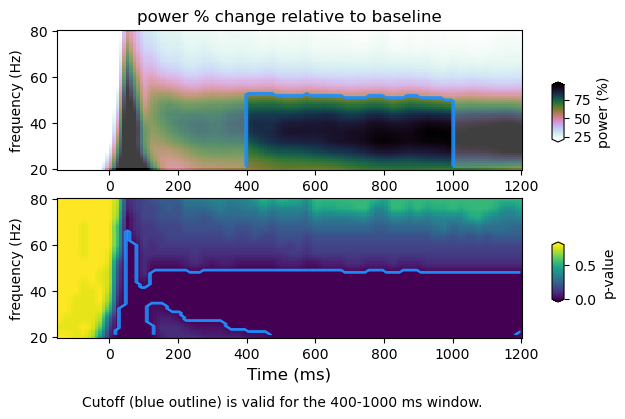

In [7]:
null         = [1, 95]
alpha        = 0.01
correction   = 1
cluster_size = 0
fband        = 1
cond         = 0
type         = 'minmax'

plot_tfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)  # pick ther min-max results and turn them into p-values

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_100.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (30, 12, 16, 113)
min = 21.35240269384813 max = 95.0319842368204
cutoff computed using whole null distribution:  70.79162686024465


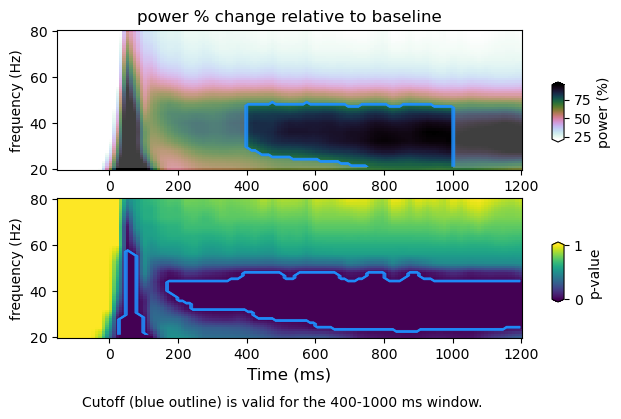

In [9]:
null         = [0, 95] #     results   = ['_100', '_100_minmax']
alpha        = 0.01
correction   = 1
cluster_size = 0
fband        = 1
cond         = 0
type         = 'whole'

plot_tfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)  # pick ther min-max results and turn them into p-values

## Cluster correction

* compute distances between time-frequency bins
* pool p-vals of nearest neighbours, defined by cluster size
* be sure all the p-vals in the cluster are above alpha
* average the p-values

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_1000_minmax.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (1000, 30, 12, 16, 2)
(16, 113)
hola: (1000, 16, 2)
(16, 113)
min = 21.35240269384813 max = 95.0319842368204
H0 dimensons : (1000, 16)
cutoff computed using truncated min/max of null distribution:  59.036714192830566


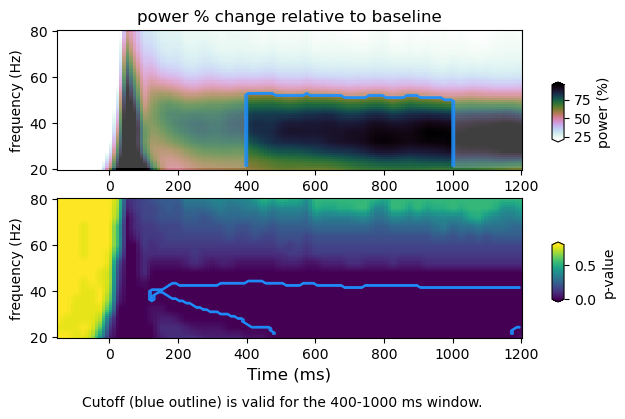

In [10]:
null         = [1, 95] #     results   = ['_100', '_100_minmax']
alpha        = 0.01
correction   = 2
cluster_size = 3
fband        = 1
cond         = 0
type         = 'minmax'

plot_tfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)  # pick ther min-max results and turn them into p-values

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_100.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (30, 12, 16, 113)
min = 21.35240269384813 max = 95.0319842368204
cutoff computed using whole null distribution:  70.79162686024465


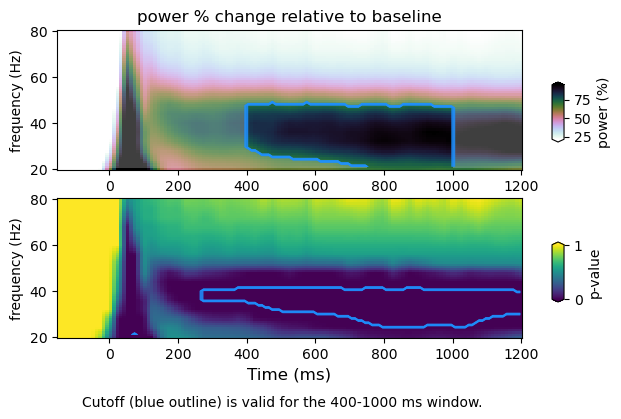

In [11]:
null         = [0, 95] #     results   = ['_100', '_100_minmax']
alpha        = 0.01
correction   = 2
cluster_size = 2
fband        = 1
cond         = 0
type         = 'whole'

plot_tfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)  # pick ther min-max results and turn them into p-values